# Derive terrain attributes from a Digital Elevation Model (DEM)

## Description
The purpose of this notebook is to compute terrain attributes from a Digital Elevation Model (DEM) for a specific area of interest. These terrain attributes provide important information about the topographic characteristics of the landscape and are particularly useful for studying wetlands. The notebook calculates various terrain indices such as aspect, curvature, Topographic Wetness Index (TWI), Terrain Profile Index (TPI), and Depth-to-Water. These indices offer insights into slope, orientation, shape, hydrology, water flow patterns, and other factors relevant to wetlands. By deriving these terrain attributes, researchers and analysts can better understand wetland dynamics, assess habitats, model ecosystems, and plan conservation strategies. The resulting terrain indices enhance wetland mapping, classification, and analysis, facilitating more accurate and detailed studies related to wetland ecosystems.

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Install and load packages" cell.

In [1]:
!pip install whitebox


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Install and load Packages

In [2]:
%matplotlib inline

import os
import time
import math
import datacube
import rasterio
import whitebox
import rioxarray
import numpy as np
import xarray as xr
import xarray as xr
import rasterio as rio
import geopandas as gpd
from pysheds.grid import Grid
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from odc.geo.geom import Geometry
from odc.dscache.tools import tiling
from datacube.utils.cog import write_cog
from scipy.ndimage import generic_filter
from datashader.transfer_functions import shade
from scipy.ndimage import label, distance_transform_edt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datacube.utils.geometry import BoundingBox

from deafrica_tools.areaofinterest import define_area
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize, xr_vectorize
from deafrica_tools.plotting import map_shapefile, display_map


import warnings
warnings.filterwarnings("ignore")

### Set up a dask cluster
This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.

In [3]:
create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:34453' processes=1 threads=4, memory=26.21 GiB>

### Initialize Datacube

In [4]:
dc = datacube.Datacube(app="DEM")

### Load vector and plot area of interest

In [5]:
# Specify a prefix to identify the area of interest in the saved outputs
# By assigning the desired prefix, you can easily identify the outputs associated with the specific area of interest.
prefix = "aoi"

# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat= -27.3048, lon= 32.6301, buffer=0.1)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='data/aoi/SANBI_Pilot.geojson')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

display_map(x=lon_range, y=lat_range)

### Explore the product names, resolution, and measurements

In [6]:
product_name = ['dem_srtm', 'dem_srtm_deriv']
resolution = (-30, 30)
measurements = 'elevation'
dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

name    dtype  units   nodata aliases  \
product        measurement                                               
dem_srtm       elevation    elevation    int16  metre -32768.0     NaN   
dem_srtm_deriv mrvbf            mrvbf    int16      1 -32768.0     NaN   
               mrrtf            mrrtf    int16      1 -32768.0     NaN   
               slope            slope  float32      1  -9999.0     NaN   

                            add_offset  scale_factor  
product        measurement                            
dem_srtm       elevation           NaN           NaN  
dem_srtm_deriv mrvbf               NaN           NaN  
               mrrtf               NaN           NaN  
               slope               NaN           NaN

### Set up reusable  query object 

In [7]:
dask_chunks = {'x': 2500, 'y': 2500}

# set up daatcube query object
query = {
    'resolution': resolution,
    'output_crs': 'epsg:6933',
    "geopolygon": geopolygon,
    'dask_chunks': dask_chunks,
    'resampling': "bilinear"
}

### Derive terrain attributes

In [8]:
# Define the output directory
output_dir = os.path.join("data/terrain_attributes/", prefix)
print(output_dir)
# Create the output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# Load the dem 30 m product
ds_elev = dc.load(product="dem_srtm", measurements='elevation',
                  **query).squeeze()
# Load the ds_deriv dataset
ds_deriv = dc.load(product="dem_srtm_deriv",
                   measurements=['mrvbf', 'mrrtf', 'slope'],
                   **query).squeeze()

data/terrain_attributes/aoi


### Clip the datasets to the shape of the area of interest
A geopolygon represents the bounds and not the actual shape because it is designed to represent the extent of the geographic feature being mapped, rather than the exact shape. In other words, the geopolygon is used to define the outer boundary of the area of interest, rather than the internal features and characteristics.

Clipping the data to the exact shape of the area of interest is important because it helps ensure that the data being used is relevant to the specific study area of interest. While a geopolygon provides information about the boundary of the geographic feature being represented, it does not necessarily reflect the exact shape or extent of the area of interest.

In [9]:
#Rasterise the area of interest polygon
aoi_raster = xr_rasterize(gdf=geopolygon_gdf,
                          da=ds_elev,
                          crs=ds_elev.crs)
#Mask the dataset to the rasterised area of interest
ds_elev = ds_elev.where(aoi_raster == 1)
ds_deriv = ds_deriv.where(aoi_raster == 1)

##### Fill DEM and export elevation to GeoTiff
The fill_depressions function aims to fill depressions (low points or sinks) in a Digital Elevation Model (DEM). The function iteratively raises the elevation of low points (depressions) in the DEM by setting them to the minimum value encountered so far, until no more depressions are detected. This process ensures that all local minima (sinks) are filled, resulting in a filled DEM where water would flow off instead of accumulating in depressions.

In [10]:
# Extract elevation data from the loaded dataset
dem = ds_elev.elevation

def fill_depressions(dem):
    # Perform depression filling using some morphological operations.
    filled_dem = dem.copy()
    while True:
        marker = filled_dem.min()
        filled_dem = np.maximum(dem, marker)
        labels, num_features = label(dem > filled_dem)
        if num_features == 0:
            break
        dem = np.maximum(dem, filled_dem)
    return filled_dem

filled_dem = fill_depressions(dem).compute()

# Save elevation to GeoTiff
elevation_path  = os.path.abspath(f"{output_dir}/Elevation.tif")
with rasterio.open(elevation_path , 'w', driver='GTiff',
                   height=filled_dem.shape[0], width=filled_dem.shape[1],
                   count=1, dtype='float32',
                   crs=dem.geobox.crs, transform=dem.geobox.affine,
                   nodata=-9999, 
                   compress='LZW') as dst:  # Use LZW compression
    dst.write(filled_dem.astype('float32'), 1)

##### Export DEM SRTM Derivatives - MrRTF and MrVBF
**Multi-resolution Valley Bottom Flatness (MrVBF)** identifies valley bottoms (areas of deposition). Zero values indicate erosional terrain and values ≥1 and indicate progressively larger areas of deposition.

**Multi-resolution Ridge Top Flatness (MrRTF)** is complementary to MrVBF, zero values indicate areas that are steep or low, and values ≥1 indicate progressively larger areas of high flat land.

In [11]:
mrrtf = ds_deriv.mrrtf.compute()
mrvbf = ds_deriv.mrvbf.compute()

write_cog(mrrtf, fname=f"{output_dir}/MrRTF.tif", overwrite=True)
write_cog(mrvbf, fname=f"{output_dir}/MrVBF.tif", overwrite=True)

PosixPath('data/terrain_attributes/aoi/MrVBF.tif')

#### Topographic Wetness Index
The ***Topographic Wetness Index (TWI)*** is a useful model to estimate where water will accumulate in an area with elevation differences. It is a function of slope and the upstream contributing area.

In [12]:
# Initialize WhiteboxTools
wbt = whitebox.WhiteboxTools()
wbt.verbose = False
wbt.work_dir = output_dir

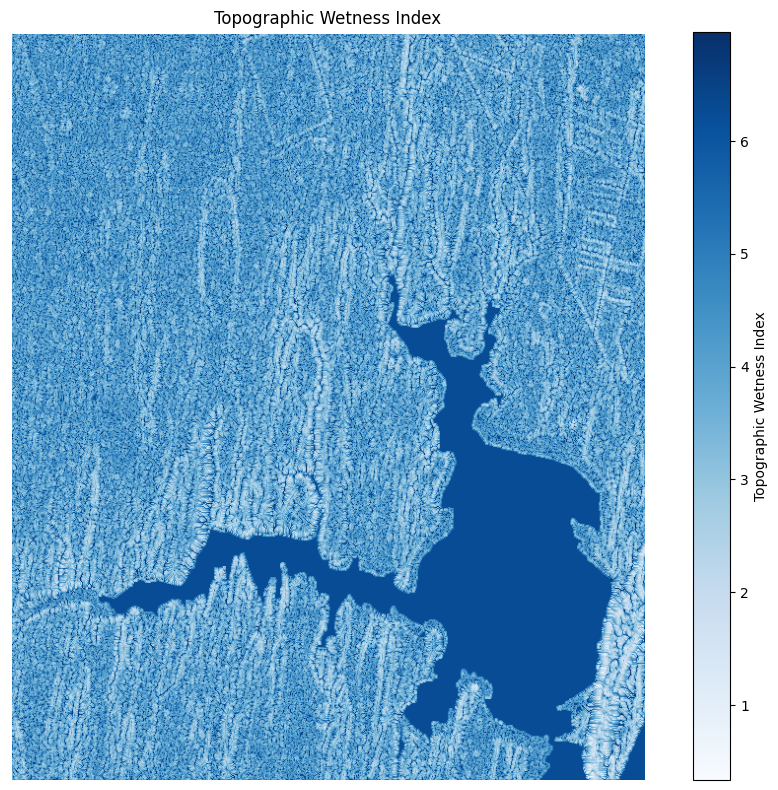

In [13]:
# Define absolute paths for input and output files
slope_path      = os.path.abspath(f"{output_dir}/slope.tif")
accum_path      = os.path.abspath(f"{output_dir}/flow_accum.tif")
twi_path        = os.path.abspath(f"{output_dir}/TWI.tif")

# Derive slope and flow accumulation
wbt.slope(elevation_path , slope_path, units='radians')
assert os.path.exists(slope_path), "Slope not created"

wbt.d8_flow_accumulation(elevation_path , accum_path, out_type='cells')
assert os.path.exists(accum_path), "Flow accumulation not created"

# Compute TWI manually (Whitebox's tool may fail in flat areas)
with rasterio.open(slope_path) as slope_src, rasterio.open(accum_path) as accum_src:
    slope  = slope_src.read(1).astype('float32')
    accum  = accum_src.read(1).astype('float32')
    crs    = slope_src.crs
    trans  = slope_src.transform
    nodata = -9999

# Prevent divide-by-zero and log-of-zero
slope[slope <= 0] = 0.001
twi = np.log(accum / (np.tan(slope) + 0.001))
twi = np.clip(twi, a_min=0, a_max=np.nanpercentile(twi, 99))  # Clip extreme outliers

# Save TWI to disk
with rasterio.open(twi_path, 'w', driver='GTiff',
                   height=twi.shape[0], width=twi.shape[1],
                   count=1, dtype='float32',
                   crs=crs, transform=trans,
                   nodata=nodata) as dst:
    dst.write(np.nan_to_num(twi, nan=nodata).astype('float32'), 1)

# Clean up intermediate slope and flow accumulation
for tmp_file in [slope_path, accum_path]:
    if os.path.exists(tmp_file):
        os.remove(tmp_file)
        
# Plot TWI
plt.figure(figsize=(10, 8))
plt.imshow(np.where(twi == nodata, np.nan, twi), cmap='Blues')
plt.colorbar(label='Topographic Wetness Index')
plt.title('Topographic Wetness Index')
plt.axis('off')
plt.tight_layout()
plt.show()


#### Depth to Water
The Depth-to-Water (DTW) index is a soil wetness indicator derived from a Digital Elevation Model (DEM). It calculates the least elevation difference between surface flow channels and surrounding landscape areas. The key points are:

* Surface Flow Channels as Reference: The DTW index considers surface flow channels, extracted from DEMs, as reference points representing the groundwater level.
* Calculation of DTW Values: DTW values are defined as zero at these surface flow channels. As you move away from these channels, the DTW values increase, reflecting greater depth to the water table and reduced soil wetness.
* Soil Wetness Indicator: A higher DTW value indicates that the area is further from surface water, suggesting lower soil moisture and drier conditions. Conversely, areas closer to surface water channels will have lower DTW values, indicating higher soil moisture.



The function calculates the DTW Index, which estimates the depth of surface water in meters based on the topographic characteristics of the terrain and the cost function for least-cost path calculation.
1. Calculates the threshold (t) for the minimal flow initiation area (FIA) based on the input parameter fia. The threshold represents how much area needs to accumulate downward the slope to result in a channel with simulated surface water. This step is necessary to determine which areas are likely to have surface water.
    * 0.25: This means that for water to start flowing, it needs to accumulate in an area of at least 0.25 hectares (2500 square meters).
    * 1: In this case, water needs to accumulate in an area of at least 1 hectare (10,000 square meters) to start flowing.
    * 4: Here, the required minimum area for water accumulation is 4 hectares (40,000 square meters).

2. Uses the calculated threshold to compare the flow accumulationto identify channels with surface water and sets them to 1 in the flowLines raster. Cells with flow accumulation below the threshold are marked as null. This step creates a binary raster layer where 1 represents channels with surface water, and null represents other areas.

3. Calculates the least-cost path of slope (cost) starting from the identified flow lines. This step helps determine the least costly path from each cell to the flow lines, considering the slope of the terrain. The cost raster will contain values representing the minimum height difference between each cell and the flow path.

4. Computes the Cartographic Depth-to-Water (DTW) Index in meters. The DTW raster is calculated by multiplying the cost raster by the spatial resolution of the DEM and dividing it by 100. This step converts the cost values (originally in percent) to represent the estimated depth of water in meters for each cell in the study area.


**References**
* [Using the Cartographic Depth-to-Water Index to Locate Small Streams and Associated Wet Areas across Landscapes](https://www.tandfonline.com/doi/full/10.4296/cwrj2011-909)
* [Evaluating the effect of DEM resolution on performance of cartographic depth-to-water maps, for planning logging operations](https://www.sciencedirect.com/science/article/pii/S030324342200054X)

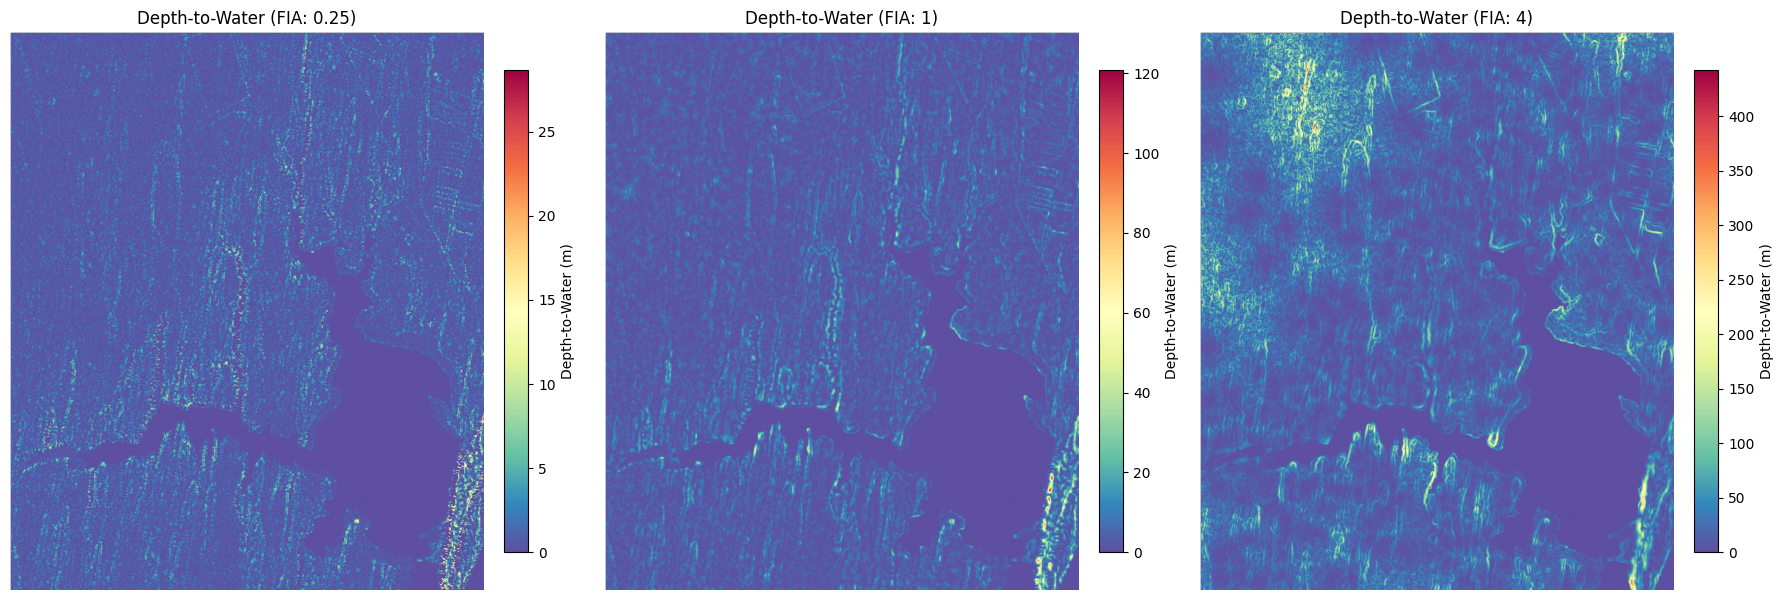

In [14]:
# Extract the slope as a NumPy array
slope = ds_deriv.slope.values # slope is already in percentage

# Open the DEM to get the transform and CRS
with rasterio.open(elevation_path ) as dem_src:
    transform = dem_src.transform
    crs = dem_src.crs

def calcDTW(fia, elevation_path, slope, transform):
    # Calculate flow accumulation threshold (cells)
    pixel_area = abs(transform.a) * abs(transform.e)  # pixel area in m²
    t = fia * 10000 / pixel_area  # FIA hectares to m² then divide by pixel area to get cell count threshold

    # Flow accumulation (D8) using WhiteboxTools
    accum_path = os.path.abspath(f"{output_dir}/flow_accum.tif")
    wbt.d8_flow_accumulation(elevation_path, accum_path, out_type='cells')

    # Read flow accumulation raster
    with rasterio.open(accum_path) as accum_src:
        accum = accum_src.read(1).astype('float32')

    # Binary mask of flow channels above threshold
    flow_lines = accum >= t

    # Distance transform: distance from each pixel to nearest flow line (in pixels)
    cost_distance = distance_transform_edt(~flow_lines)

    # Convert pixel distance to meters
    pixel_size = abs(transform.a)  
    distance_meters = cost_distance * pixel_size

    # Convert slope percent to slope radians
    slope_radians = np.arctan(slope / 100)

    # Calculate vertical Depth To Water (DTW) in meters
    DTW = distance_meters * np.tan(slope_radians)

    # Clean up flow accumulation file
    os.remove(accum_path)

    return DTW

# Set the FIA value you want to use
fia_values = [0.25, 1, 4]
dtw_results = []

for fia in fia_values:
    dtw = calcDTW(fia, elevation_path, slope, transform).astype(np.float32)
    dtw_results.append(dtw)

fig, axes = plt.subplots(1, len(fia_values), figsize=(18, 6))

for ax, fia, dtw in zip(axes, fia_values, dtw_results):
    im = ax.imshow(dtw, cmap='Spectral_r')
    ax.set_title(f'Depth-to-Water (FIA: {fia})')
    ax.axis('off')
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Depth-to-Water (m)')

plt.tight_layout()
plt.show()


#### Derive multi-scale terrain indices
These include Slope, Curvature, Planform Curvature and Profile Curvature and Topographic Postion Index (TPI).

The ***Topographic Position Index (TPI)*** is a metric of slope position based on the method of Weiss (2001). It is defined as the difference between the elevation of a central pixel and the average elevation of its surrounding pixels. The unit of TPI corresponds to that of the Digital Elevation Model (DEM), typically in meters. TPI can be computed for any window size (default: 3x3 pixels). 

By varying the window size, different terrain characteristics can be captured. Smaller windows highlight fine-scale terrain features, while larger windows reveal broader landform patterns.

**Moving Window Approach**
The moving window approach involves sliding a defined window across the raster data to compute spatial metrics. The window size determines the extent of the neighbourhood around each pixel. As the window moves pixel by pixel, it calculates the metric (e.g., slope, curvature) based on the pixels within the window. The neighbourhood around each pixel is defined by one of three spatial contiguity matrices, namely, Queen's, Rook's and Bishop's case contiguity which are explained below. This approach allows for the calculation of local terrain indices that reflect the characteristics of each pixel relative to its surrounding area. The window size can be adjusted to capture different spatial scales and nuances in the terrain, providing flexibility in the analysis. Larger windows capture broader patterns, while smaller windows focus on more localised features.

**Queen's case contiguity**
* Definition: In the 'queen' method, a cell is considered contiguous if it shares an edge or a corner with the neighboring cell. This includes all eight surrounding cells.
* Matrix Representation: The xl_mat, xr_mat, yt_mat, and yb_mat matrices define connectivity by setting the entire edges of the window to 1, allowing diagonals to be considered as neighbors.
* Usage: This method captures more complex spatial relationships because it includes diagonal neighbors. It is often used when you want to include all potential neighbors, providing a more connected neighborhood.

**Rook's case contiguity**
* Definition: In the 'rook' method, a cell is considered contiguous only if it shares an edge with another cell, excluding diagonal neighbors. This means only the directly adjacent cells (up, down, left, right) are considered neighbors.
* Matrix Representation: The xl_mat, xr_mat, yt_mat, and yb_mat matrices define connectivity by setting only the central row or column on each edge to 1, excluding diagonals.
* Usage: This method is simpler and often used when you want to include only directly adjacent neighbors. It provides a less connected neighborhood compared to the 'queen' method but is simpler computationally.

**Bishop's case contiguity**

* Definition: In the 'bishop' method, a cell is considered contiguous if it shares a corner with another cell, similar to the movement of a bishop in chess. This includes only diagonal neighbors. Thus, a cell is connected to the four diagonal cells that surround it.
* Matrix Representation: The xl_mat, xr_mat, yt_mat, and yb_mat matrices define connectivity based on diagonal relationships. For the bishop contiguity, these matrices are filled to represent the diagonals, allowing cells connected diagonally to be included.
* Usage: This method captures relationships that involve diagonal connections, excluding the directly adjacent cells. It provides a neighborhood that connects cells diagonally, which can be useful for certain spatial analyses where diagonal connections are more relevant than edge-sharing ones.

**Circle Neighborhood**

* Definition: The neighborhood is defined by a circular area centered on the pixel, rather than a strict square matrix.
* Matrix Representation:  A circular mask is applied to the window, including only pixels whose Euclidean distance from the center is within a specified radius.
* Usage: seful for capturing terrain characteristics in a more natural way, avoiding the biases introduced by square windows.

**Annulus Neighborhood**

* Definition:  Similar to the circle method, but excludes the innermost pixels, forming a ring-like structure around the center pixel.
* Matrix Representation: An annular mask is applied, keeping pixels within a defined outer radius while removing those inside a smaller inner radius.
* Usage: his method is effective for isolating terrain patterns at different spatial scales by emphasizing a specific range of distances.

#### Computational Considerations

* The window size influences the results significantly. Smaller windows focus on local variations, while larger windows capture broader topographic patterns.
* The method of spatial connectivity affects the interpretation of terrain indices.
* Depending on the size of the study area and the chosen parameters, processing time may vary.

In [15]:
def create_kernel(w, method):
    kx, ky = w
    kernel = np.zeros((ky, kx))
    jy, jx = ky // 2, kx // 2  # Center of the kernel

    if method == 'queen':
        kernel[:, :] = 1
    elif method == 'rook':
        kernel[jy, :] = 1  # Horizontal
        kernel[:, jx] = 1  # Vertical
    elif method == 'bishop':
        np.fill_diagonal(kernel, 1)
        np.fill_diagonal(np.fliplr(kernel), 1)
    elif method == 'circle':
        y, x = np.ogrid[-jy:jy+1, -jx:jx+1]
        mask = x**2 + y**2 <= (kx // 2) ** 2
        kernel[mask] = 1
    elif method == 'annulus':
        y, x = np.ogrid[-jy:jy+1, -jx:jx+1]
        outer_mask = x**2 + y**2 <= (kx // 2) ** 2
        inner_mask = x**2 + y**2 < ((kx // 2) - 1) ** 2
        kernel[outer_mask] = 1
        kernel[inner_mask] = 0
    
    return kernel

def terrain_indices(filled_dem, w=(3, 3), unit='degrees', method='queen'):
    if min(w) < 3:
        raise ValueError("Window size must be at least 3x3")
    if w[0] % 2 == 0 or w[1] % 2 == 0:
        raise ValueError("Window size must be odd")
    
    kernel = create_kernel(w, method)
    
    def focal_mean(arr, kernel):
        kernel = kernel / kernel.sum()
        return ndimage.convolve(arr, kernel, mode='constant', cval=np.nan)
    
    start_time = time.time()
    smoothed_dem = focal_mean(filled_dem, kernel)
    dz_dx, dz_dy = np.gradient(smoothed_dem)
    slope_k = np.arctan(np.hypot(dz_dx, dz_dy))
    if unit == 'degrees':
        slope_k = np.degrees(slope_k)
    
    aspect_k = (-np.pi / 2) - np.arctan2(dz_dy, dz_dx)
    aspect_k = np.where(aspect_k < 0, aspect_k + 2 * np.pi, aspect_k)
    if unit == 'degrees':
        aspect_k = np.degrees(aspect_k)
    
    dz2_dx2 = focal_mean(dz_dx, kernel) - dz_dx
    dz2_dy2 = focal_mean(dz_dy, kernel) - dz_dy
    dz2_dxdy = focal_mean(dz_dx, kernel) - focal_mean(dz_dy, kernel)
    
    curvature_k = dz2_dx2 + dz2_dy2
    profile_curvature_k = dz2_dy2 * np.cos(aspect_k)**2 + dz2_dx2 * np.sin(aspect_k)**2 + 2 * dz2_dxdy * np.sin(aspect_k) * np.cos(aspect_k)
    planform_curvature_k = dz2_dy2 * np.sin(aspect_k)**2 + dz2_dx2 * np.cos(aspect_k)**2 - 2 * dz2_dxdy * np.sin(aspect_k) * np.cos(aspect_k)
    
    focal_mean_tpi = focal_mean(smoothed_dem, kernel)
    tpi_k = smoothed_dem - focal_mean_tpi
    
    result = {'Slope': slope_k, 'Curvature': curvature_k, 'Profile_curvature': profile_curvature_k,
              'Planform_curvature': planform_curvature_k, 'TPI': tpi_k}
    
    print(f"Terrain indices computed in {time.time() - start_time:.2f} seconds")
    return result

def array_to_dataarray(array, filled_dem, metric):
    return xr.DataArray(
        array,
        dims=["y", "x"],
        coords={"y": filled_dem.coords["y"], "x": filled_dem.coords["x"]},
        attrs={"crs": filled_dem.attrs["crs"], "nodata": filled_dem.attrs.get("nodata", None)}
    ).rename(metric)

data = {}
window_sizes = [(3,3),(9,9), (15,15)]

for w in window_sizes:
    print(f'Processing window size: {w}')
    results = terrain_indices(filled_dem, w=w)
    for metric, result in results.items():
        if metric not in data:
            data[metric] = {}
        data[metric][w] = result
        result_da = array_to_dataarray(result, filled_dem, metric)
        write_cog(result_da, fname=f"{output_dir}/{metric}_{30 * w[0]}m.tif", overwrite=True)
    print(f"All indices for {w} saved to {output_dir}")

Processing window size: (3, 3)
Terrain indices computed in 0.08 seconds
All indices for (3, 3) saved to data/terrain_attributes/aoi
Processing window size: (9, 9)
Terrain indices computed in 0.38 seconds
All indices for (9, 9) saved to data/terrain_attributes/aoi
Processing window size: (15, 15)
Terrain indices computed in 0.95 seconds
All indices for (15, 15) saved to data/terrain_attributes/aoi


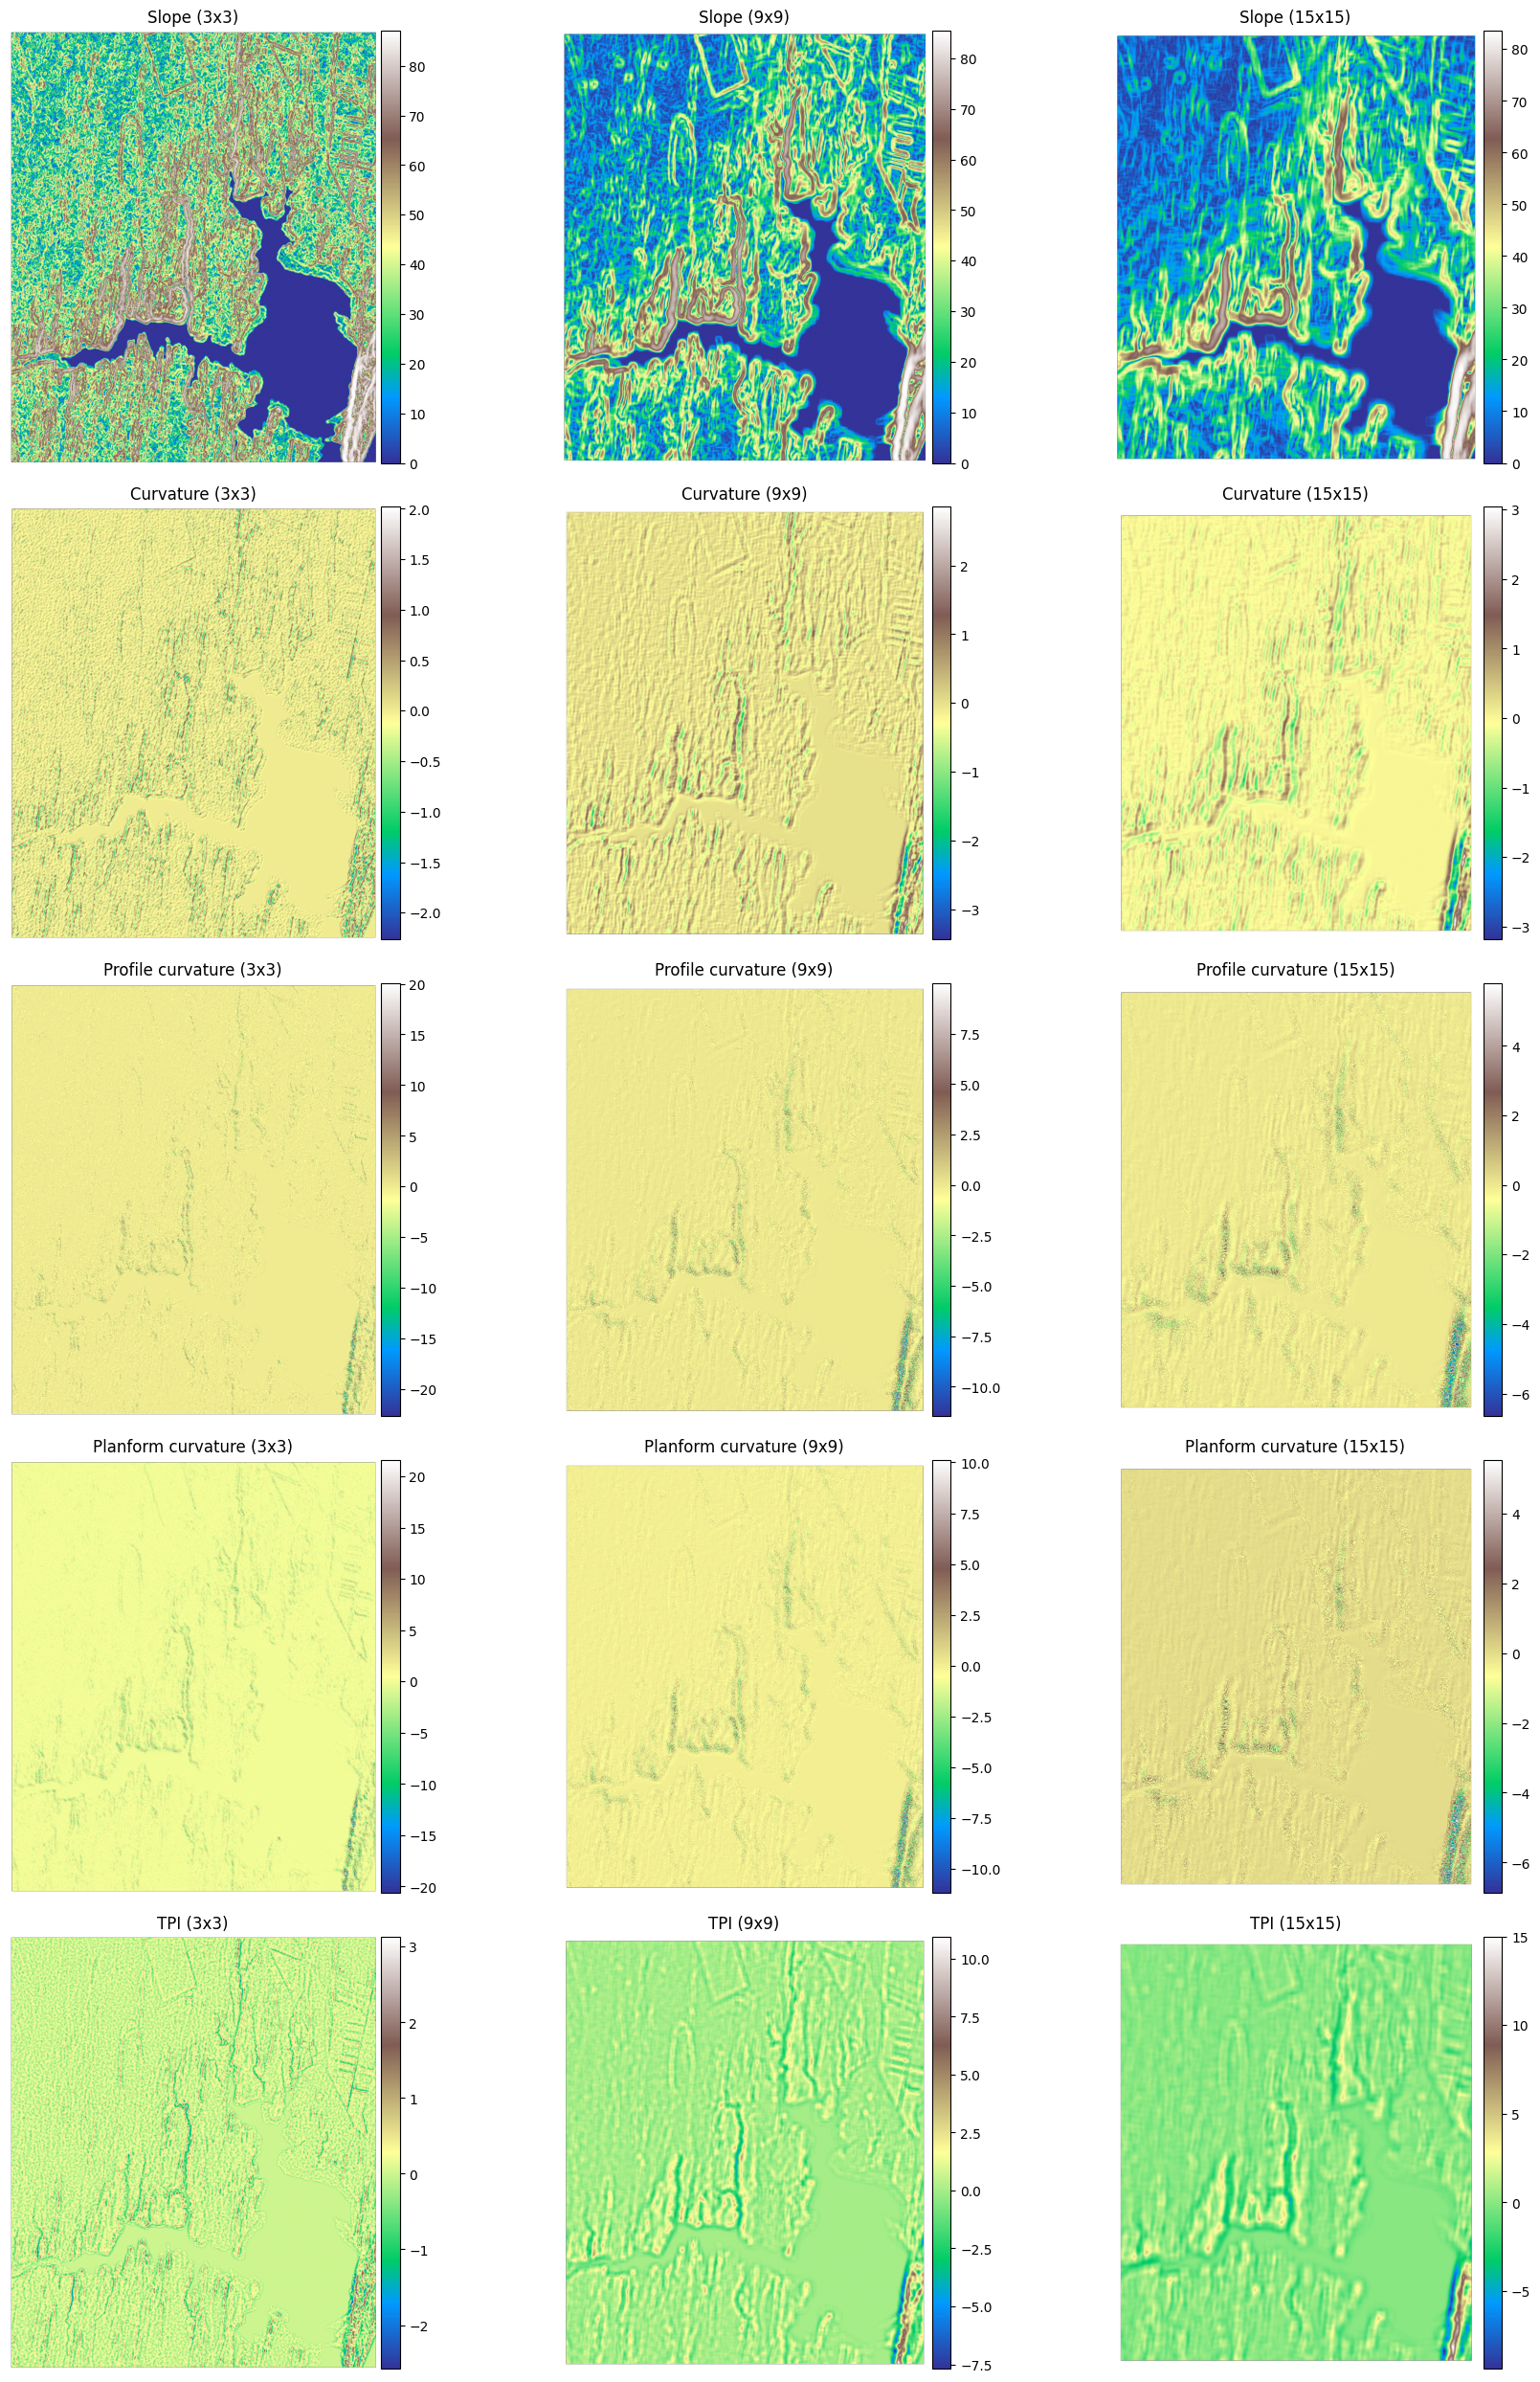

In [16]:
fig, axes = plt.subplots(len(data), len(window_sizes), figsize=(18, 5 * len(data)))

# Ensure axes is always a 2D array
if len(data) == 1:
    axes = np.expand_dims(axes, axis=0)
if len(window_sizes) == 1:
    axes = np.expand_dims(axes, axis=1)

for i, (metric, windows_data) in enumerate(data.items()):
    for j, w in enumerate(window_sizes):
        ax = axes[i, j]
        im = ax.imshow(windows_data[w], cmap='terrain', origin='upper')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        ax.set_title(f'{metric} ({w[0]}x{w[1]})'.replace('_', ' '))
        ax.axis('off')
plt.tight_layout()
plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [17]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-07-10'